# RXID : Pill Shape Identifier 
## Using TFlearn for TensorFlow to design a ConvNet that detects Pill Shapes

## Imports and Parameters

In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage of progress bar for tasks.

## Set path to Training Data

### Connect to Google Drive

In [ ]:
# !python -m pip install tqdm
# !python -m pip install tensorflow
# !python -m pip install tflearn
# !pip install --upgrade numpy
from google.colab import drive
GDRIVE_DIR = '/content/gdrive' 
drive.mount(GDRIVE_DIR)
TRAIN_DIR = GDRIVE_DIR+'/My Drive/csv/train'
TEST_DIR  = GDRIVE_DIR+'/My Drive/csv/test'
SAVE_DIR = GDRIVE_DIR+'/My Drive/csv'

### Or Local Drive

In [2]:
TRAIN_DIR = 'D:/GITHUB/Pill_Shape_Training_Images/train'
TEST_DIR  = 'D:/GITHUB/Pill_Shape_Training_Images/test'
SAVE_DIR = 'D:/GITHUB/Pill_Shape_Training_Images/save'

In [3]:
#_____________   Init Vars ______________________
IMG_LENGTH = 100   # Image length
IMG_HEIGHT = 100   # Image height
LR = 1e-5        # Learning Rate = .000001
num_epochs = 30  # Number of Epochs
num_class_types = 2  # number of classification types

#  Loss Function
if num_class_types < 3:
  loss_function = 'binary_crossentropy'
else:
  loss_function = 'categorical_crossentropy'

# just so we remember which saved model is which, sizes must match
MODEL_NAME = 'CapRndOval-{}-{}.model'.format(LR, '2conv-basic') 
# MODEL_NAME = SAVE_DIR +'/'+MODEL_NAME
# print(MODEL_NAME)

## Create + Shuffle Training & Test Images

For each shape:  OVAL, ROUND,  CAPSULE

    1300/200: Train/Validate
         500: Test

In [4]:
import cv2
# https://www.edureka.co/community/719/how-to-resize-the-image-canvas-maintain-square-aspect-ratio

def resizeAndPad(img, size, padColor=255):
    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA

    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = float(w)/h 
    saspect = float(sw)/sh

    if (saspect > aspect) or ((saspect == 1) and (aspect <= 1)):  # new horizontal image
        new_h = sh
        new_w = np.round(new_h * aspect).astype(int)
        pad_horz = float(sw - new_w) / 2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0

    elif (saspect < aspect) or ((saspect == 1) and (aspect >= 1)):  # new vertical image
        new_w = sw
        new_h = np.round(float(new_w) / aspect).astype(int)
        pad_vert = float(sh - new_h) / 2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

In [5]:
# ____ label the image ____
'''    based on 1st 3 letters of filename
       rnd, cap, or ovl  must be used to identify the shape 
       in the filename ____'''

def label_img(img):
    word_label = img.split('.')[-3]  
    # ____ Conversion to one-hot array _____________________    
    if num_class_types < 3:
        # __ ___ Binary classification_____     [rnd,cap]     
        if   word_label == 'rnd': return [1,0]  # [1, 0]
        elif word_label == 'cap': return [0,1]  # [0, 1]
    else:
        # __ Multivariate classification____      [rnd,cap,ovl]     
        if   word_label == 'rnd': return [1,0,0]  # [1, 0, 0]
        elif word_label == 'cap': return [0,1,0]  # [0, 1, 0]
        elif word_label == 'ovl': return [0,0,1]  # [0, 0, 1]

# ____ create list of numpy arrays based on resized images ____
def process_images(image_dir, save_filename):
    image_list = []
    ctr = 0
    for img in tqdm(os.listdir(image_dir)):
        # ___only image files____
        if ('.jpg' in str(img)) or ('.png' in str(img)):
            label = label_img(img)
            path = os.path.join(image_dir,img)
            try:
              img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
              img = cv2.resize(img, (IMG_LENGTH, IMG_HEIGHT))
              #__Save np.arrays representing the image & label __
              image_list.append([np.array(img),np.array(label)])
              ctr += 1
            except :
              pass #print(img)
    if ctr == 0:
        print('Warning NO images were found. Verify correct file location')
    else:
        print(f'{ctr} images labeled')
        # ___ shuffle the list ____
        shuffle(image_list)
        print(f'{ctr} images from {image_dir} have been labeled & shuffled')
        #  ___ save the image data to a np file ___
        np.save(save_filename, image_list)
        print(f'Image data saved to file:{save_filename}')
    return image_list

In [6]:
#  Create train and test data sets

train_data = process_images(TRAIN_DIR, SAVE_DIR+'/train_data.npy')
test_data  = process_images(TEST_DIR, SAVE_DIR+'/test_data.npy')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:04<00:00, 707.87it/s]


3000 images labeled
3000 images from D:/GITHUB/Pill_Shape_Training_Images/train have been labeled & shuffled
Image data saved to file:D:/GITHUB/Pill_Shape_Training_Images/save/train_data.npy


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 729.08it/s]


1000 images labeled
1000 images from D:/GITHUB/Pill_Shape_Training_Images/test have been labeled & shuffled
Image data saved to file:D:/GITHUB/Pill_Shape_Training_Images/save/test_data.npy


## Load Preprocessed Training & Test Data

In [7]:
# _Load Pre-saved train / test data

train_data = np.load(SAVE_DIR+'/train_data.npy', allow_pickle=True)
test_data = np.load(SAVE_DIR+'/test_data.npy', allow_pickle=True)

## Create X,y for Training &  Validation Set

In [8]:
# Select last 200 observations of training set for validation
train = train_data[:-200]
validation = train_data[-200:]

#  Create Train X / Y
X = np.array([i[0] for i in train]).reshape(-1,IMG_LENGTH,IMG_HEIGHT,1)
Y = [i[1] for i in train]


# Create Validation X/ Y  For validation set:
val_x = np.array([i[0] for i in validation]).reshape(-1,IMG_LENGTH,IMG_HEIGHT,1)
val_y = [i[1] for i in validation]

## Setup Convolutional Neural Net model with 6 layers

In [9]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_LENGTH, IMG_HEIGHT, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, num_class_types, activation='softmax')   # num_class_types is the number of classification types we are predicting
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss=loss_function, name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='/log')

curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Train the Model

In [10]:
model.fit({'input': X}, {'targets': Y}, n_epoch=num_epochs, validation_set=({'input': val_x}, {'targets': val_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1319  | total loss: 0.52914 | time: 17.579s
| Adam | epoch: 030 | loss: 0.52914 - acc: 0.9546 -- iter: 2752/2800
Training Step: 1320  | total loss: 0.52742 | time: 18.987s
| Adam | epoch: 030 | loss: 0.52742 - acc: 0.9576 | val_loss: 0.52163 - val_acc: 0.9700 -- iter: 2800/2800
--


## Save Trained Model for later use

In [11]:
model.save(SAVE_DIR +'/'+MODEL_NAME)

INFO:tensorflow:D:/GITHUB/Pill_Shape_Training_Images/save/CapRndOval-1e-05-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [ ]:
# from tutorial
# https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/
# !tensorboard --logdir=content/log

## Load Pre-Trained Model

In [15]:
# __ Activate this code to reload model ____ 
# __ if we have a saved version          ___

if os.path.exists('{}.meta'.format(SAVE_DIR +'/'+MODEL_NAME)):
    model.load(SAVE_DIR +'/'+MODEL_NAME)
    print('model loaded!')
else:
    print('model NOT Found!')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from D:/GITHUB/Pill_Shape_Training_Images/save/CapRndOval-1e-05-2conv-basic.model
model loaded!


##  Separate Test data in to X,y

In [16]:
# NOTE!!! --->> array[:,0] and array[:,1] did NOT work <---
# HERE! Separating features and labels:
test_x = np.array([i[0] for i in test_data]).reshape(-1, IMG_LENGTH, IMG_HEIGHT, 1)
test_y = [i[1] for i in test_data]

## Predict using Test data

### Display first 25 predictions

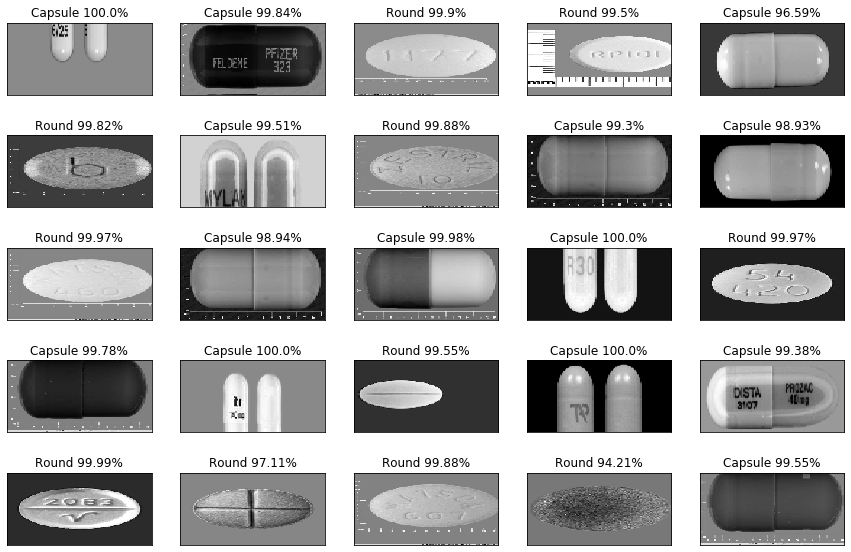

In [18]:
import matplotlib.pyplot as plt
shapes = { 0:"Round",
           1:"Capsule",
           2:"Oval"}
fig=plt.figure(figsize=(15.0, 10.0))  #width, height in inches.
for indx, data in enumerate(test_data[-25:]):
    img_nparray = data[1]
    img_data    = data[0]
    y = fig.add_subplot(5,5,indx+1)
    data = img_data.reshape(IMG_LENGTH, IMG_HEIGHT, 1)
    model_out = model.predict([data])[0]
    str_label = shapes.get(np.argmax(model_out))
    plt.title(str_label+' ' + str(round (model_out[np.argmax(model_out)]*100,2))+'%')
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    y.imshow(img_data, cmap='gray')
    y.axes.set_aspect(.5)
plt.show()

###  Predict on All Test Data

In [19]:
import pandas as pd

shapes = { 0:"Round",
           1:"Capsule",
           2:"Oval"}

# ___ make predictions on test_x ___ 
predictions = model.predict(test_x)

# __ Add descriptive labels to actuals(test_y) & predictions __
pred_label = []
for pred in predictions:
    prediction = shapes.get(np.argmax(pred))
    pred_label.append(prediction)
test_label= []
for actual in test_y:
    label = shapes.get(np.argmax(actual))
    test_label.append(label)    

# __ Setup a dataframe of prediction results __
df = pd.DataFrame(list(zip(test_label, pred_label)), 
                  columns =['Real', 'Prediction'])

# ____ Add an Accuracy Column ____
def accuracy_col(row):
      return (row['Real'] == row['Prediction'])
df['Correct'] = df.apply(lambda row: accuracy_col(row), axis=1)    

# __ Print Result Summary __
df.Correct.value_counts()
print(f'{df.Correct.value_counts()[1]} correct and {df.Correct.value_counts()[0]} incorrect predictions made\n')
print(f'Accuracy : {round(df.Correct.value_counts()[1]/len(df)*100,2)}%\n')
df.tail()

988 correct and 12 incorrect predictions made

Accuracy : 98.8%



,Real,Prediction,Correct
995,Round,Round,True
996,Round,Round,True
997,Round,Round,True
998,Round,Round,True
999,Capsule,Capsule,True


In [22]:
df['Real'].value_counts()

Capsule    500
Round      500
Name: Real, dtype: int64

In [23]:
df['Prediction'].value_counts()

Capsule    503
Round      497
Name: Prediction, dtype: int64